In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from minopy.objects.invert_pixel import process_pixel 
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

In [3]:
project_dir = './Miami_data'
out_dir = './out_figures'
#os.chdir(project_dir)

out_amplitude = project_dir + '/mean_amplitude'


In [31]:
def get_data(ymin, ymax, xmin, xmax, ps, out_amplitude, shift=0):
    demError_file = project_dir + '/demErr.h5'
    demError_std_file = project_dir + '/demErr_std.h5'

    vel_file = project_dir + '/velocity.h5'
    geo_file = project_dir + '/org_geometry/geometryRadar.h5'
    #dsm_file = project_dir + '/dsm.h5'

    phs_file = project_dir + '/phase_series.h5'
    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'

    
    mask_w = np.flipud(readfile.read(mask_file_w, datasetName='mask')[0][ymin:ymax, xmin:xmax])
    mask_t = np.flipud(readfile.read(mask_file_t, datasetName='mask')[0][ymin:ymax, xmin:xmax])*mask_w
    mask_p = np.flipud(readfile.read(mask_file_ps, datasetName='mask')[0][ymin:ymax, xmin:xmax])*mask_w
    #
    
    if ps:
        mask = mask_p
    else:
        mask=mask_t

    DEM = np.flipud(readfile.read(geo_file, datasetName='height')[0][ymin:ymax, xmin:xmax]) + shift

    demError = np.flipud(readfile.read(demError_file, datasetName='dem')[0][ymin:ymax, xmin:xmax])
    demError_std = np.flipud(readfile.read(demError_std_file, datasetName='dem')[0][ymin:ymax, xmin:xmax]) 

    velocity, atr = readfile.read(vel_file, datasetName='velocity')
    velocity = np.flipud(velocity[ymin:ymax, xmin:xmax])
  
    am_memmap = gdal.Open(out_amplitude + '.vrt', gdal.GA_ReadOnly)
    amplitude = np.flipud(am_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))

    vel = velocity[mask==1]*1000
   
    demerr = demError[mask==1]
    dem = DEM[mask==1]
    demerror_std = demError_std[mask==1]

    x = np.linspace(0, velocity.shape[1]-1, velocity.shape[1])
    y = np.linspace(0, velocity.shape[0]-1, velocity.shape[0])
    x, y = np.meshgrid(x, y)

    xv = x[mask==1]
    yv = y[mask==1]
    
    return amplitude, xv, yv, vel, demerr, dem, demerror_std, DEM, atr


def plot_subset(ymin, ymax, xmin, xmax, ps, vel_range, amplitude_im, dem_offset, dem_name, out_name, out_dir, size=100):
    
    amplitude, xv, yv, vel, demerr, dem, demerror_std, DEM, atr = get_data(ymin, ymax, xmin, xmax, ps, amplitude_im, dem_offset)
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    #amplitude = (amplitude - np.min(amplitude))/(np.max(amplitude) - np.min(amplitude))
    
    ax = axs[0,0]
    ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    im = ax.scatter(xv, yv, c=vel, s=size, cmap='jet', vmin=-vel_range, vmax=vel_range); 
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('velocity [mm/yr]')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    ax = axs[0,1]
    im=ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('Amplitude')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    ax = axs[1,0]
    ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    im = ax.scatter(xv, yv, c=dem, s=size, cmap='jet'); 
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('SRTM DEM [m]')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    ax = axs[1,1]
    ax.imshow(amplitude, cmap='gray', vmin=0, vmax=300)
    im = ax.scatter(xv, yv, c=dem-demerr, s=size, cmap='jet'); 
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, orientation='horizontal', pad=0.02)
    cbar.set_label('Estimated elevation [m]')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
    ax.axes.get_yaxis().set_visible(False)
    
    if ps:
        psds = 'ps'
    else:
        psds = 'ds'
    #plt.savefig(out_dir + '/{}_{}_{}.png'.format(out_name, dem_name, psds), dpi=300)


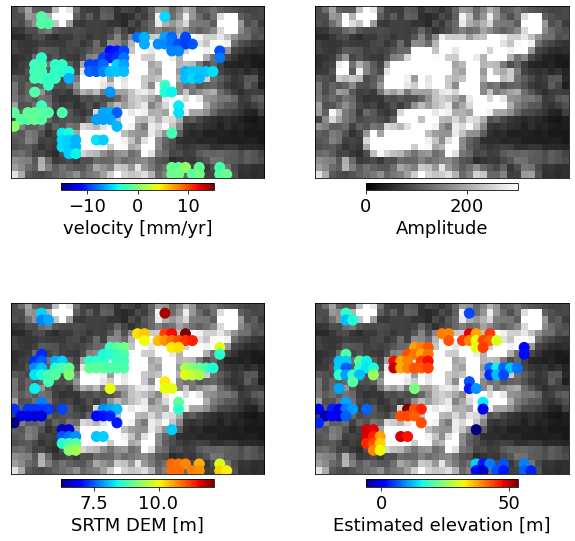

In [32]:

plt.rcParams["font.size"] = "18"

plot_subset(ymin=319, ymax=344, xmin=1490, xmax=1527, ps=True, vel_range=15,
            amplitude_im=out_amplitude, dem_offset=26, dem_name='Sdem', 
            out_name='hotel_radar_coord', out_dir=out_dir, size=100)


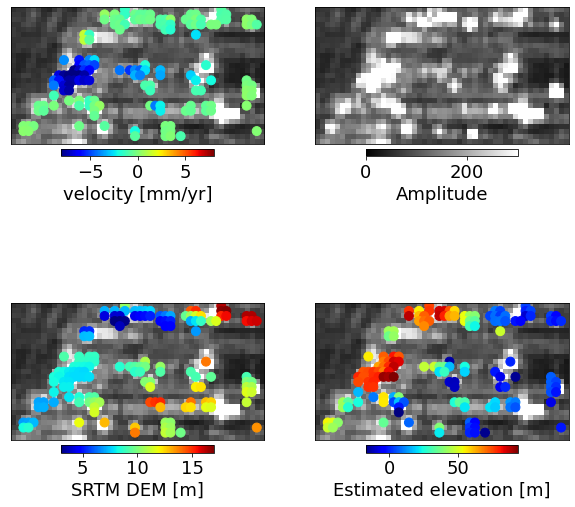

In [33]:
plot_subset(ymin=458, ymax=485, xmin=1530, xmax=1580, ps=True, vel_range=8,
            amplitude_im=out_amplitude, dem_offset=26, dem_name='Sdem', 
            out_name='oceana_radar_coord', out_dir=out_dir, size=80)

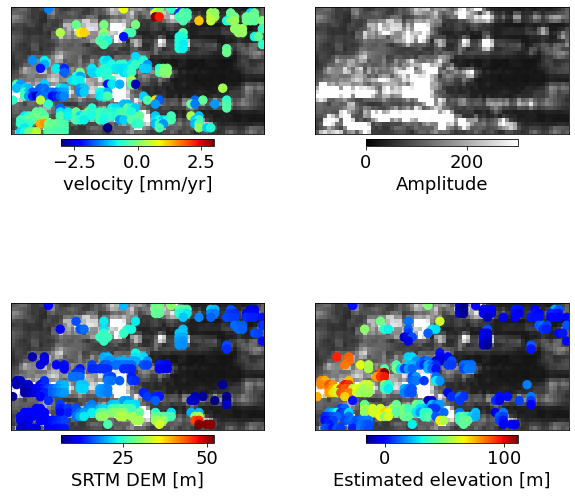

In [34]:
plot_subset(ymin=408, ymax=440, xmin=1506, xmax=1570, ps=True, vel_range=3,
            amplitude_im=out_amplitude, dem_offset=26, dem_name='Sdem', 
            out_name='Regis_radar_coord', out_dir=out_dir, size=70)

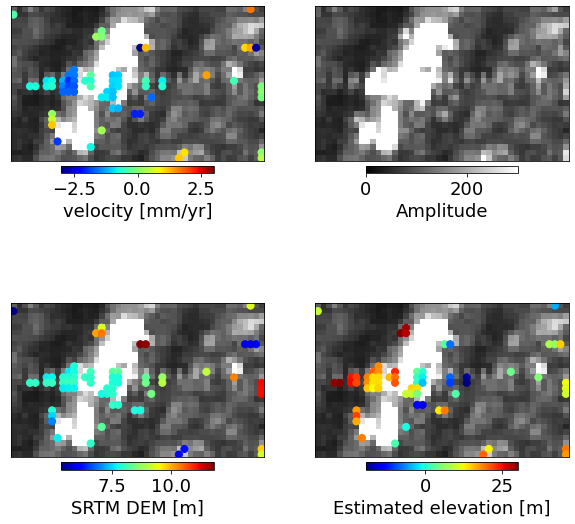

In [35]:

plot_subset(ymin=430, ymax=458, xmin=1212, xmax=1258, ps=True, vel_range=3,
            amplitude_im=out_amplitude, dem_offset=26, dem_name='Sdem', 
            out_name='kai_radar_coord', out_dir=out_dir, size=50)

